In [15]:
import pandas as pd
import random
import logging
import numpy as np
import matplotlib.pyplot as plt

In [16]:
logging.basicConfig(filename='project1.log',level=logging.DEBUG)

In [17]:
class Classifier:
    """
    
        A wrapper class containing a 2-class
        learning model with two separate classifiers,
        one using the Winnow-2 algorithms and the other
        using the Naive Bayes algorithm
        
        Alpha and theta are set permanently here for
        the sake of brevity
        
    """
    def __init__(self,name,src,data):
        self.name = name
        self.src = src
        self.data = data
        self.models = [
            # I only set two models, but more can be added
            Winnow2Model(name,2.0,0.5),
            NaiveBayesModel(name)
        ]
    
    def __str__(self):
        return 'name={},src={},models={}'.format(self.name,self.src,self.models)

    def train(self):
        # train the model with the data contained in the object
        for model in self.models:
            logging.info('training {} ({})'.format(model.name,type(model).__name__))
            model.train(self.data['train'],self.data)
    
    def test(self):
        # test the classifiers against the data contained in the object
        results = {}
        for model in self.models:
            results[type(model).__name__] = []
            logging.info('processing {} ({})'.format(model.name,type(model).__name__))
            results[type(model).__name__].append(model.process(self.data['test'],self.data))
        return results

In [18]:
# class for storing a 2-class, boolean Winnow-2 model
class Winnow2Model:
    """
    
        This class constructs a 2-class model
        using the Winnow-2 algorithm.
        
    """    
    def __init__(self,name,alpha,theta):
        self.weights = []
        self.name = name
        self.alpha = alpha
        self.theta = theta
    
    def __str__(self):
        return 'model={},alpha={},theta={}'.format(self.name,self.alpha,self.theta)
    
    def train(self,data,xs):
        self.__init__(self.name,self.alpha,self.theta) # reset values for re-training
        self.weights = [1]*(len(data[0])-1) # set initial weights to 1
        for d in data:
            # if the summation of weights * feature value is over the threshold,
            # assume it is a positive classification
            pclass = 1 if self.compute_sum(d) > self.theta else 0 
                
            aclass = d[-1] # get the correct class
            
            if pclass is not aclass: # if it isn't, promote or demote
                self.promote(d) if pclass == 0 else self.demote(d)
        logging.info('summary: weights={}'.format(self.weights))
            
    def process(self,data,xs):
        hits = 0
        for i, d in enumerate(data):
            pclass = 1 if self.compute_sum(d) > self.theta else 0
            hits = hits + 1 if pclass == d[-1] else hits
        logging.info('summary: {}/{} hits, accuracy {}%'.format(hits,len(data),hits*100/len(data)))
        return hits*100/len(data)
        
    def demote(self,instance):
        for i,x in enumerate(instance[:-1]):
            self.weights[i] = self.weights[i] / self.alpha if x == 1 else self.weights[i]
        
    def promote(self,instance):
        for i,x in enumerate(instance[:-1]):
            self.weights[i] = self.weights[i] * self.alpha if x == 1 else self.weights[i]
    
    def compute_sum(self,instance):
        """ computes summation of the products of each feature value and its respective weight """
        rsum = 0
        for i,d in enumerate(instance[:-1]):
            rsum += (self.weights[i]*d)
        return rsum

In [19]:
# class for storing a 2-class, boolean Naive Bayes model
class NaiveBayesModel:
    """
    
        This class constructs a 2-class model
        using the Naive Bayes algorithm. The format for
        every class has been standardized: data is
        assumed to follow the structure:
        [ [<instance data>, class], [<instance data>, class], ...]
        Positive instances are denoted with a class = 1;
        others with a class = 0. Since all instance data is
        maintained in binary form (1/0), class = 0 may
        refer to multiple other classes but is generalized
        here to one other class. Conditional probabilities
        of the features are described as their 'probability
        of equaling 1' for a given class; the inverse can
        be determined quickly when evaluating the probability
        of the feature equaling 0.
        
    """      
    def __init__(self,name):
        self.name = name
        self.class_probs = []
        self.alt_probs = []

    def __str__(self):
        return 'model={},class_probs={},alt_probs={}'.format(self.name,self.class_probs,self.alt_probs)
    
    def train(self,data,xs):
        self.__init__(self.name) # resets values for retraining
        class_data = list(filter(lambda x: x[-1] == 1,data))
        alt_data = list(filter(lambda x: x[-1] == 0,data))

        class_len = len(class_data)
        alt_len = len(alt_data)
        
        class_freq = class_len / len(data)
        alt_freq = alt_len / len(data)
        
        for i in range(len(data[0]) - 1):
            f = lambda x: x[i]
            class_subset = [f(x) for x in class_data]
            alt_subset = [f(x) for x in alt_data]
            self.class_probs.append(class_subset.count(1) / class_len)
            self.alt_probs.append(alt_subset.count(1) / alt_len)
        
        # maintains the structure [ <feature probability of 1 given the class>, class probability ]
        self.class_probs.append(class_freq)
        self.alt_probs.append(alt_freq)
        
        logging.info('summary: class_probs={}, alt_probs={}'.format(self.class_probs,self.alt_probs))
                
    def process(self,data,xs):
        hits = 0
        for i, d in enumerate(data):
            class_prob = self.compute_prob(self.class_probs,d)
            alt_prob = self.compute_prob(self.alt_probs,d)
            pclass = 1 if class_prob > alt_prob else 0
            hits = hits + 1 if pclass == d[-1] else hits
        logging.info('summary: {}/{} hits, accuracy {}%'.format(hits,len(data),hits*100/len(data)))
        return hits*100/len(data)
    
    def compute_prob(self,probs,data):
        prob = probs[-1]
        for i, d in enumerate(data[:-1]):
            prob *= probs[i] if d else (1 - probs[i])
        return prob

In [20]:
def create_class(filename,classname,discriminant,start,end,class_index):
    """
        Function designed to coordinate processing
        raw training and testing data and providing
        it to a model.
        
        All data formats, both training and  testing,
        are standardized here as follows:
        
        [ [<instance data>, class], [<instance data>, class], ...]
        
        Positive instances are denoted with class = 1;
        others with a class = 0. This will differ based on
        the class being trained. For example, to train the
        Boolean model to identify political affiliation based
        on votes, a dataset is provided with all instances
        of "democrat" flagged with class = 1 -- this will
        create a class identifying democrats. Conversely, if
        training a republican class with the same data, all
        data that was flagged as "republican" (class = 0) will
        now be class = 1 and all "democrat" instances will be
        class = 0
        
        All instance data is maintained in binary form (1/0),
        which requires custom discrimination functions that act
        to translate features to a 1 or 0 value
        
    """
    
    df = pd.read_csv(filename, header=None)
    class_data = []
    
    # create a new instance with each row in the file, appending the correct class to the end
    for row in df.iterrows():
        aclass = 1 if str(row[1][class_index]) == classname else 0
        new_row = [discriminant(i,f) for i,f in enumerate(row[1][start:end+1])] + [aclass]
        class_data.append(new_row)

    train_data, train_map, test_data, test_map = [], [], [], []
    
    data_map = [int(i) for i in range(len(class_data))]
    class_len = int(len(class_data))
    train_len = int(class_len * 2/3)
    test_len = class_len - train_len
    
    # randomnly populate a training set while maintaing a map (map is for troubleshooting)
    for i in range(train_len):
        r = random.randint(0,len(data_map)-1)
        train_data.append(class_data[data_map[r]])
        train_map.append(df.loc[data_map[r]])
        data_map.remove(data_map[r])
        
    # randomnly populate a training set while maintaing a map (map is for troubleshooting) 
    for i in range(test_len):
        r = random.randint(0,len(data_map)-1)        
        test_data.append(class_data[data_map[r]])
        test_map.append(df.loc[data_map[r]])
        data_map.remove(data_map[r])    
    
    # the final data object to be maintained in each model object
    data = {
        'train': train_data,
        'test' : test_data,
        'train_map' : train_map,
        'test_map' : test_map
    }
        
    return Classifier(classname,filename,data)

In [21]:
"""
    Below are the test functions with specialized configurations
    meant to map the raw content of each dataset to a compatible
    format. The create a new model
"""

'\n    Below are the test functions with specialized configurations\n    meant to map the raw content of each dataset to a compatible\n    format. The create a new model\n'

In [22]:
def test_voting(rounds):
    start_index = 1
    end_index = 16
    class_index = 0
    filename = 'data/voting-records/house-votes-84.data'
    discriminant = lambda i,x: 1 if x == 'y' else (0 if x == 'n' else random.getrandbits(1))
    classes = ['democrat', 'republican']
    
    return sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index)

In [23]:
def test_wbcd(rounds):
    start_index = 1
    end_index = 9
    class_index = 10
    filename = 'data/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
    df = pd.read_csv(filename, header=None)
    df = df.apply(pd.to_numeric, errors='coerce')
    mean = [df[i].mean() for i in range(start_index,end_index+1)]
    mad = [df[i].mad() for i in range(start_index,end_index+1)]
    discriminant = lambda i,x: random.getrandbits(1) if x == '?' else (1 if (abs(int(x) - mean[i]) < mad[i]) else 0)
    classes = ['2', '4']
    
    return sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index)

In [24]:
def test_iris(rounds):
    start_index = 0
    end_index = 3
    class_index = 4
    filename = 'data/iris/iris.data'
    df = pd.read_csv(filename, header=None)
    df = df.apply(pd.to_numeric, errors='coerce')
    mean = [df[i].mean() for i in range(start_index,end_index+1)]
    mad = [df[i].mad() for i in range(start_index,end_index+1)]
    discriminant = lambda i,x: random.getrandbits(1) if x == '?' else (1 if (abs(int(x) - mean[i]) < mad[i]) else 0)
    classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

    return sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index)

In [25]:
def test_soybean(rounds):
    start_index = 0
    end_index = 34
    class_index = 35
    filename = 'data/soybean/soybean-small.data'
    df = pd.read_csv(filename, header=None)
    df = df.apply(pd.to_numeric, errors='coerce')
    mean = [df[i].mean() for i in range(start_index,end_index+1)]
    mad = [df[i].mad() for i in range(start_index,end_index+1)]
    discriminant = lambda i,x: random.getrandbits(1) if x == '?' else (1 if (abs(int(x) - mean[i]) < mad[i]) else 0)
    classes = ['D1', 'D2', 'D3', 'D4']
    
    return sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index)

In [26]:
def test_glass(rounds):
    start_index = 1
    end_index = 9
    class_index = 10
    filename = 'data/glass/glass.data'
    df = pd.read_csv(filename, header=None)
    df = df.apply(pd.to_numeric, errors='coerce')
    mean = [df[i].mean() for i in range(start_index,end_index+1)]
    mad = [df[i].mad() for i in range(start_index,end_index+1)]
    discriminant = lambda i,x: random.getrandbits(1) if x == '?' else (1 if (abs(int(x) - mean[i]) < mad[i]) else 0)
    classes = ['1.0', '2.0', '3.0', '5.0', '6.0', '7.0']
    
    return sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index)

In [27]:
def sampling(rounds, classes, filename, discriminant, start_index, end_index, class_index):
    """
        Key function that iteratively creates, trains, and tests
        models, measuring and compiling the accuracy of the
        resulting models
    """
    results = {}
    max_results = {}
    best = {}
    for cls in classes:
        best[cls] = {}
        for r in range(rounds):
            my_cls = create_class(filename, cls, discriminant, start_index, end_index, class_index)
            my_cls.train()
            tmp_results = my_cls.test()
            for t in tmp_results.keys():
                if t not in best[cls]:
                    best[cls][t] = tmp_results[t]
                elif best[cls][t] < tmp_results[t]:
                    best[cls][t] = tmp_results[t]
                else:
                    if t not in results:
                        results[t] = tmp_results[t]
                    else:
                        results[t] = results[t] + tmp_results[t]
        for mdl in best[cls]:
            if mdl not in max_results:
                max_results[mdl] = best[cls][mdl]
            else:
                max_results[mdl] += best[cls][mdl]
    return max_results, results

In [28]:
wbcd_max_results, wbcd_results = test_wbcd(100) # train, test, and measure performance x100 times

In [29]:
glass_max_results, glass_results = test_glass(100)

In [30]:
iris_max_results, iris_results = test_iris(100)

In [31]:
soybean_max_results, soybean_results = test_soybean(100)

In [32]:
voting_max_results, voting_results = test_voting(100)

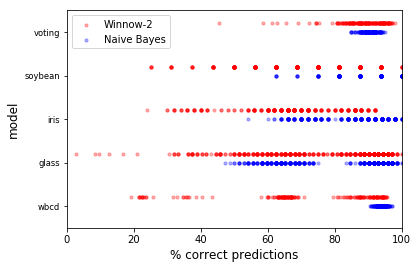

In [40]:
# plot all of the results on a scatterplot

results = [
    {'values' : wbcd_results, 'name' : 'wbcd'},
    {'values' : glass_results, 'name' : 'glass'},
    {'values' : iris_results, 'name' : 'iris'},
    {'values' : soybean_results, 'name' : 'soybean'},
    {'values' : voting_results, 'name' : 'voting'}
]

import pprint
logging.info('RESULTS: ' + pprint.pformat(results))

Y_AXIS = ['wbcd', 'glass', 'iris', 'soybean', 'voting']
area = 10

tfxr = {}
for i,r in enumerate(results):
    nb_x = r['values']['NaiveBayesModel']
    nb_y = [i]*len(r['values']['NaiveBayesModel'])
    w2_x = r['values']['Winnow2Model']
    w2_y = [i+0.2]*len(r['values']['Winnow2Model'])
    w2 = plt.scatter(w2_x, w2_y, s=area, alpha=0.3, color='r')
    nb = plt.scatter(nb_x, nb_y, s=area, alpha=0.3, color='b')
    if(i == 0):
        plt.legend([w2, nb], ['Winnow-2', 'Naive Bayes'], loc='upper left')

plt.xlabel('% correct predictions', fontsize=12)
plt.yticks(range(len(Y_AXIS)), Y_AXIS, size='small')
plt.ylabel('model', fontsize=12)
plt.axis((0.0,100.0,-0.5,4.5))

plt.show()

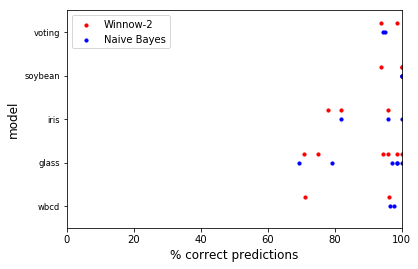

In [42]:
# plot only the best class results on a scatterplot

results = [
    {'values' : wbcd_max_results, 'name' : 'wbcd'},
    {'values' : glass_max_results, 'name' : 'glass'},
    {'values' : iris_max_results, 'name' : 'iris'},
    {'values' : soybean_max_results, 'name' : 'soybean'},
    {'values' : voting_max_results, 'name' : 'voting'}
]

import pprint
logging.info('RESULTS: ' + pprint.pformat(results))

Y_AXIS = ['wbcd', 'glass', 'iris', 'soybean', 'voting']
area = 10

tfxr = {}
for i,r in enumerate(results):
    nb_x = r['values']['NaiveBayesModel']
    nb_y = [i]*len(r['values']['NaiveBayesModel'])
    w2_x = r['values']['Winnow2Model']
    w2_y = [i+0.2]*len(r['values']['Winnow2Model'])
    w2 = plt.scatter(w2_x, w2_y, s=area, alpha=1, color='r')
    nb = plt.scatter(nb_x, nb_y, s=area, alpha=1, color='b')
    if(i == 0):
        plt.legend([w2, nb], ['Winnow-2', 'Naive Bayes'], loc='upper left')

plt.xlabel('% correct predictions', fontsize=12)
plt.yticks(range(len(Y_AXIS)), Y_AXIS, size='small')
plt.ylabel('model', fontsize=12)
plt.axis((0.0,100.0,-0.5,4.5))

plt.show()